In [ ]:
# azureml-core of version 1.0.72 or higher is required
from azureml.core import Workspace, Dataset

subscription_id = 'afc8afff-59cf-4a3f-85d3-6b742b7a5aa2'
resource_group = 'resource'
workspace_name = 'hackthenorth'

workspace = Workspace(subscription_id, resource_group, workspace_name)

dataset = Dataset.get_by_name(workspace, name='dog_audio')
dataset.download(target_path='../data/dog', overwrite=False)

In [19]:
# Move files into correct folders
for f in os.listdir('../data/dog'):
    if '.wav' in f:
        find = re.compile(r"^[^.]*")
        result = re.search(find, f)
        shutil.move('../data/dog/'+f, '../data/dog/'+result.group(0)[-1])

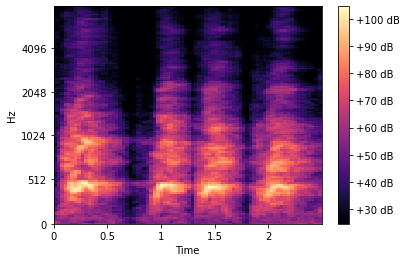

In [48]:
test = '../data/dog/a/dog_barking_10a.wav'
samples, sample_rate = librosa.load(test, sr=None)
sgram = librosa.stft(samples)
sgram_mag, _ = librosa.magphase(sgram)
mel_scale_sgram = librosa.feature.melspectrogram(S=sgram_mag, sr=sample_rate)
librosa.display.specshow(mel_scale_sgram)
mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=np.min)
librosa.display.specshow(mel_sgram, sr=sample_rate, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')

In [49]:
import re
import shutil
import librosa.display
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
import torchaudio
from torch.utils.data import DataLoader
from torchaudio import transforms
import numpy as np
import torchvision
import sys
sys.path.insert(1, '../script')

from model import EfficientNetNotRGB

from torch.utils.data import DataLoader, Dataset, random_split
#from efficientnet_pytorch import EfficientNet

ModuleNotFoundError: No module named 'utils'

In [2]:
# Count files
import os
directory = 'dog'
classes = os.listdir('../data/'+directory)
value_count = {}
for clas in classes:
    files = os.path.join('../data/'+directory, clas)
    value_count[clas] = len(os.listdir(files))
print('total: '+str(sum(value_count.values())))
value_count

total: 153


{'a': 26, 'b': 39, 'c': 7, 'd': 4, 'f': 6, 'g': 17, 'h': 33, 'i': 16, 'j': 5}

In [ ]:
#!pip install torchaudio -f https://download.pytorch.org/whl/torch_stable.html
#!pip install librosa
#!pip install efficientnet_pytorch

In [3]:
import math, random
import torch
import torchaudio
from torchaudio import transforms
from IPython.display import Audio

#src code - https://towardsdatascience.com/audio-deep-learning-made-simple-sound-classification-step-by-step-cebc936bbe5
class AudioUtil():
  # ----------------------------
  # Load an audio file. Return the signal as a tensor and the sample rate
  # ----------------------------
  @staticmethod
  def open(audio_file):
    sig, sr = torchaudio.load(audio_file)
    return (sig, sr)
    # ----------------------------
  # Convert the given audio to the desired number of channels
  # ----------------------------
  @staticmethod
  def rechannel(aud, new_channel):
    sig, sr = aud

    if (sig.shape[0] == new_channel):
      # Nothing to do
      return aud

    if (new_channel == 1):
      # Convert from stereo to mono by selecting only the first channel
      resig = sig[:1, :]
    else:
      # Convert from mono to stereo by duplicating the first channel
      resig = torch.cat([sig, sig])

    return ((resig, sr))
    # ----------------------------
  # Since Resample applies to a single channel, we resample one channel at a time
  # ----------------------------
  @staticmethod
  def resample(aud, newsr):
    sig, sr = aud

    if (sr == newsr):
      # Nothing to do
      return aud

    num_channels = sig.shape[0]
    # Resample first channel
    resig = torchaudio.transforms.Resample(sr, newsr)(sig[:1,:])
    if (num_channels > 1):
      # Resample the second channel and merge both channels
      retwo = torchaudio.transforms.Resample(sr, newsr)(sig[1:,:])
      resig = torch.cat([resig, retwo])

    return ((resig, newsr))
    # ----------------------------
  # Convert the given audio to the desired number of channels
  # ----------------------------
  @staticmethod
  def rechannel(aud, new_channel):
    sig, sr = aud

    if (sig.shape[0] == new_channel):
      # Nothing to do
      return aud

    if (new_channel == 1):
      # Convert from stereo to mono by selecting only the first channel
      resig = sig[:1, :]
    else:
      # Convert from mono to stereo by duplicating the first channel
      resig = torch.cat([sig, sig])

    return ((resig, sr))
    # ----------------------------
  # Pad (or truncate) the signal to a fixed length 'max_ms' in milliseconds
  # ----------------------------
  @staticmethod
  def pad_trunc(aud, max_ms):
    sig, sr = aud
    num_rows, sig_len = sig.shape
    max_len = sr//1000 * max_ms

    if (sig_len > max_len):
      # Truncate the signal to the given length
      sig = sig[:,:max_len]

    elif (sig_len < max_len):
      # Length of padding to add at the beginning and end of the signal
      pad_begin_len = random.randint(0, max_len - sig_len)
      pad_end_len = max_len - sig_len - pad_begin_len

      # Pad with 0s
      pad_begin = torch.zeros((num_rows, pad_begin_len))
      pad_end = torch.zeros((num_rows, pad_end_len))

      sig = torch.cat((pad_begin, sig, pad_end), 1)
      
    return (sig, sr)
    # ----------------------------
  # Shifts the signal to the left or right by some percent. Values at the end
  # are 'wrapped around' to the start of the transformed signal.
  # ----------------------------
  @staticmethod
  def time_shift(aud, shift_limit):
    sig,sr = aud
    _, sig_len = sig.shape
    shift_amt = int(random.random() * shift_limit * sig_len)
    return (sig.roll(shift_amt), sr)
    # ----------------------------
  # Generate a Spectrogram
  # ----------------------------
  @staticmethod
  def spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None):
    sig,sr = aud
    top_db = 80

    # spec has shape [channel, n_mels, time], where channel is mono, stereo etc
    spec = transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)

    # Convert to decibels
    spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
    return (spec)
# ----------------------------
  # Augment the Spectrogram by masking out some sections of it in both the frequency
  # dimension (ie. horizontal bars) and the time dimension (vertical bars) to prevent
  # overfitting and to help the model generalise better. The masked sections are
  # replaced with the mean value.
  # ----------------------------
  @staticmethod
  def spectro_augment(spec, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1):
    _, n_mels, n_steps = spec.shape
    mask_value = spec.mean()
    aug_spec = spec

    freq_mask_param = max_mask_pct * n_mels
    for _ in range(n_freq_masks):
      aug_spec = transforms.FrequencyMasking(freq_mask_param)(aug_spec, mask_value)

    time_mask_param = max_mask_pct * n_steps
    for _ in range(n_time_masks):
      aug_spec = transforms.TimeMasking(time_mask_param)(aug_spec, mask_value)

    return aug_spec

In [41]:
#!/usr/bin/python
# -*- coding: utf-8 -*-

# ----------------------------
# Sound Dataset
# ----------------------------


class SoundDS(Dataset):

    def __init__(self, data_path, transform=None):
        self.data_path = str(data_path)
        self.duration = 5000
        self.sr = 44100
        self.channel = 2
        self.shift_pct = 0.4
        self.transform = transform

  # ----------------------------
  # Number of items in dataset
  # ----------------------------

    def __len__(self):
        classes = os.listdir(self.data_path)
        num_classes = len(classes)
        tot = 0
        for clas in classes:
            files = os.path.join(self.data_path, clas)
            tot = tot + len(os.listdir(files))
        return tot

    def value_counts(self):
        tot = 0
        classes = os.listdir(self.data_path)
        value_count = {}
        for clas in classes:
            files = os.path.join(self.data_path, clas)
            tot = tot + len(os.listdir(files))
        return tot

  # ----------------------------
  # Get i'th item in dataset
  # ----------------------------

    def get_labels(self):
        classes = sorted(os.listdir(self.data_path))
        num_classes = len(classes)
        labels = []
        for clas in classes:
            files = os.path.join(self.data_path, clas)
            for file in os.listdir(files):
                labels.append(classes.index(clas))
            return labels

    def __getitem__(self, idx):
        classes = sorted(os.listdir(self.data_path))
        num_classes = len(classes)
        tot = 0
        for clas in classes:
            files = os.path.join(self.data_path, clas)
            for file in os.listdir(files):
                if not '.aml' in file:
                    if tot == idx:
                        pth = os.path.join(files, file)
                        aud = AudioUtil.open(pth)

                    # Some sounds have a higher sample rate, or fewer channels compared to the
                    # majority. So make all sounds have the same number of channels and same
                    # sample rate. Unless the sample rate is the same, the pad_trunc will still
                    # result in arrays of different lengths, even though the sound duration is
                    # the same.

                        reaud = AudioUtil.resample(aud, self.sr)
                        rechan = AudioUtil.rechannel(reaud,
                                self.channel)
                        dur_aud = AudioUtil.pad_trunc(rechan,
                                self.duration)
                        shift_aud = AudioUtil.time_shift(dur_aud,
                                self.shift_pct)
                        sgram = AudioUtil.spectro_gram(shift_aud,
                                n_mels=64, n_fft=1024, hop_len=None)
                        aug_sgram = AudioUtil.spectro_augment(sgram,
                                max_mask_pct=0.1, n_freq_masks=2,
                                n_time_masks=2)
                        aug_sgram = self.transform(np.array(aug_sgram))
                        aug_sgram = torch.reshape(aug_sgram, (aug_sgram.shape[1],aug_sgram.shape[0],aug_sgram.shape[2]))
                        return (aug_sgram, classes.index(clas))
                    tot = tot + 1


In [42]:
batch_size = 16
num_classes = 9
train_directory = 'dog'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
use_transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
dt = SoundDS(data_path='../data/'+train_directory, transform=use_transform)
print(dt.value_counts())

149


In [43]:


train_len = int(0.8*len(dt))
val_len = int(0.1*len(dt))
test_len = len(dt) - train_len - val_len
train_dt, val_dt, test_dt = torch.utils.data.random_split(dt, [train_len,val_len,test_len],generator=torch.Generator().manual_seed(27))
train_loader = DataLoader(train_dt, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dt, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dt, batch_size=batch_size, shuffle=False)
print(len(train_dt), 'TRAIN LEN')
print(len(val_dt), 'VAL LEN')
print(len(test_dt), 'TEST LEN')

119 TRAIN LEN
14 VAL LEN
16 TEST LEN


In [44]:

# for i in range(len(train_dt)):
#     inputs, labels = train_dt[i]
#     print('INSIDE LOOP')
#     print(inputs.shape)
#     print(labels)
    #inputs = inputs.to(device, dtype=torch.float)
    #labels = labels.to(device)
for inputs, labels in train_loader:
    print('INSIDE LOOP')
    print(inputs.shape)
    print(labels)

torch.Size([2, 430, 64])
torch.Size([2, 430, 64])
torch.Size([2, 430, 64])
torch.Size([2, 430, 64])
torch.Size([2, 430, 64])
torch.Size([2, 430, 64])
torch.Size([2, 430, 64])
torch.Size([2, 430, 64])
torch.Size([2, 430, 64])
torch.Size([2, 430, 64])
torch.Size([2, 430, 64])
torch.Size([2, 430, 64])
torch.Size([2, 430, 64])
torch.Size([2, 430, 64])
torch.Size([2, 430, 64])
torch.Size([2, 430, 64])
INSIDE LOOP
torch.Size([16, 2, 430, 64])
tensor([0, 1, 7, 1, 1, 6, 1, 8, 5, 2, 6, 0, 0, 1, 1, 3])
torch.Size([2, 430, 64])
torch.Size([2, 430, 64])
torch.Size([2, 430, 64])
torch.Size([2, 430, 64])
torch.Size([2, 430, 64])
torch.Size([2, 430, 64])
torch.Size([2, 430, 64])
torch.Size([2, 430, 64])
torch.Size([2, 430, 64])
torch.Size([2, 430, 64])
torch.Size([2, 430, 64])
torch.Size([2, 430, 64])
torch.Size([2, 430, 64])
torch.Size([2, 430, 64])
torch.Size([2, 430, 64])
torch.Size([2, 430, 64])
INSIDE LOOP
torch.Size([16, 2, 430, 64])
tensor([6, 0, 0, 5, 7, 5, 1, 5, 1, 7, 1, 8, 5, 0, 1, 0])
torc

KeyboardInterrupt: 

In [76]:
# find corrupted files
tot = 0
data_path = '../data/dog'
classes = os.listdir(data_path)
value_count = {}
print(classes)
for clas in classes:
    files = os.listdir(os.path.join(data_path, clas))
    for file in files:
        if '.aml' not in file:
            print(clas, file)
            aud = AudioUtil.open('../data/dog/'+clas+'/'+file)
            # Some sounds have a higher sample rate, or fewer channels compared to the
            # majority. So make all sounds have the same number of channels and same
            # sample rate. Unless the sample rate is the same, the pad_trunc will still
            # result in arrays of different lengths, even though the sound duration is
            # the same.
            duration = 5000
            sr = 44100
            channel = 2
            shift_pct = 0.4
            reaud = AudioUtil.resample(aud, sr)
            rechan = AudioUtil.rechannel(reaud,
                    channel)
            dur_aud = AudioUtil.pad_trunc(rechan,
                    duration)
            shift_aud = AudioUtil.time_shift(dur_aud,
                    shift_pct)
            sgram = AudioUtil.spectro_gram(shift_aud,
                    n_mels=64, n_fft=1024, hop_len=None)
            aug_sgram = AudioUtil.spectro_augment(sgram,
                    max_mask_pct=0.1, n_freq_masks=2,
                    n_time_masks=2)
            print(aug_sgram.shape)
        

['a', 'b', 'c', 'd', 'f', 'g', 'h', 'i', 'j']
a dog_12a.wav
torch.Size([2, 64, 430])
a dog_15a.wav
torch.Size([2, 64, 430])
a dog_17a.wav
torch.Size([2, 64, 430])
a dog_19a.wav
torch.Size([2, 64, 430])
a dog_29a.wav
torch.Size([2, 64, 430])
a dog_40a.wav
torch.Size([2, 64, 430])
a dog_44a.wav
torch.Size([2, 64, 430])
a dog_8a.wav
torch.Size([2, 64, 430])
a dog_barking_0a.wav
torch.Size([2, 64, 430])
a dog_barking_104a.wav
torch.Size([2, 64, 430])
a dog_barking_105a.wav
torch.Size([2, 64, 430])
a dog_barking_10a.wav
torch.Size([2, 64, 430])
a dog_barking_110a.wav
torch.Size([2, 64, 430])
a dog_barking_12a.wav
torch.Size([2, 64, 430])
a dog_barking_14a.wav
torch.Size([2, 64, 430])
a dog_barking_17a.wav
torch.Size([2, 64, 430])
a dog_barking_24a.wav
torch.Size([2, 64, 430])
a dog_barking_6a.wav
torch.Size([2, 64, 430])
a dog_barking_87a.wav
torch.Size([2, 64, 430])
a dog_barking_88a.wav
torch.Size([2, 64, 430])
a dog_barking_93a.wav
torch.Size([2, 64, 430])
a dog_barking_97a.wav
torch.Siz

In [74]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b1', num_classes = num_classes)


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b1-f1951068.pth" to /home/azureuser/.cache/torch/hub/checkpoints/efficientnet-b1-f1951068.pth


  0%|          | 0.00/30.1M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b1


In [ ]:
import sys
sys.path.insert(1, 'script')
from model import EfficientNetNotRGB
from AudioUtil import AudioUtil
import torchvision

def evaluate():
    # Initialize variables
    num_classes = 9
    model_name = 'dog_audio_effB1_ep150/dog_audio_effB1_ep150val_acc_0.7142857142857143val_loss_0.10887178033590317'
    duration = 5000 # 5 sec
    sr = 44100
    channel = 2
    shift_pct = 0.4
    # Decide which device we want to run on
    device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
    
    # create model object
    deepNet = EfficientNetNotRGB.from_pretrained('efficientnet-b1',num_classes=num_classes)
    
    # load generator
    states = torch.load('models/'+model_name)
    deepNet.load_state_dict(states['model_state_dict'])
    deepNet.eval()
    # process image
    aud = AudioUtil.open('../data/dog/a/dog_12a.wav')
    reaud = AudioUtil.resample(aud, sr)
    rechan = AudioUtil.rechannel(reaud, channel)
    dur_aud = AudioUtil.pad_trunc(rechan, duration)
    shift_aud = AudioUtil.time_shift(dur_aud, shift_pct)
    sgram = AudioUtil.spectro_gram(shift_aud, n_mels=64, n_fft=1024, hop_len=None)
    aug_sgram = AudioUtil.spectro_augment(sgram, max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2)
    use_transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
    aug_sgram = use_transform(aug_sgram)
    aug_sgram = torch.reshape(aug_sgram, (aug_sgram.shape[1],aug_sgram.shape[0],aug_sgram.shape[2]))
    output = deepNet(aug_sgram)
    print(output)